In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
def preprocessing(arr, seq_length):
    df = pd.DataFrame(arr, columns = ["time0"])
    buffer = df.copy()
    for i in range(1, seq_length + 1):
        df[f"time{i}"] = buffer.shift(i)
    res = np.array(df[list(df.columns)[1:]].dropna())
    return res.reshape(res.shape[0], res.shape[1], 1)

# 模型建模

In [3]:
class Encoder(nn.Module):
    def __init__(self, n_features, n_hidden, n_layers):
        super(Encoder, self).__init__()
        # LSTM 所有時間點 整合資訊
        self.lstm = nn.LSTM(input_size = n_features, 
                            hidden_size = n_hidden, 
                            num_layers = n_layers,
                            bias = True, 
                            batch_first = True
                           )
        
    def forward(self, x):
        _, (hid, cel) = self.lstm(x)
        return hid, cel
    
class Decoder(nn.Module):
    def __init__(self, seq_length, n_features, n_hidden, n_layers):
        super(Decoder, self).__init__()
        self.seq_length = seq_length
        self.n_features = n_features
        self.lstm_cell = nn.LSTMCell(input_size = n_features, 
                                     hidden_size = n_hidden, 
                                     bias = True
                                    )
        self.dense = nn.Linear(n_hidden, n_features)
    def forward(self, hid):
        res = torch.tensor([]).to(torch.float32).to(device = "cuda")
        hid = [h.squeeze() for h in hid]
        x_hat = self.dense(hid[0])
        for time in range(self.seq_length):
            hid = self.lstm_cell(x_hat, hid)
            x_hat = self.dense(hid[0])
            res = torch.cat([res, x_hat], axis = 1)
        
        return res.reshape(-1, self.seq_length, self.n_features)
    
class RAE(nn.Module):
    def __init__(self, seq_length, n_features, n_hidden, n_layers):
        super(RAE, self).__init__()
        self.seq_length = seq_length
        self.encoder = Encoder(n_features, n_hidden, n_layers)
        self.decoder = Decoder(seq_length, n_features, n_hidden, n_layers)
    def forward(self, x):
        hid = self.encoder(x)
        out = self.decoder(hid)
        return torch.flip(out, [1]) # encoder最強烈的反而是最後一個時間點，所以flip


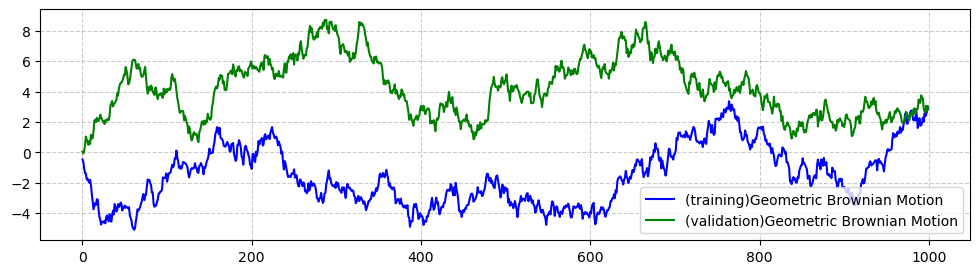

In [4]:
mu = 0.05
sigma = .3
arr = (mu - 0.5*sigma)*np.arange(1000)*(1/1000) + np.cumsum(sigma*np.random.normal(0, 1, size = (1000, )))
val_arr = (mu - 0.5*sigma)*np.arange(1000)*(1/1000) + np.cumsum(sigma*np.random.normal(0, 1, size = (1000, )))
plt.figure(figsize = (12, 3))
plt.plot(arr, color = "blue", label = "(training)Geometric Brownian Motion")
plt.plot(val_arr, color = "green", label = "(validation)Geometric Brownian Motion")
plt.grid(linestyle = "--", color = 'gray', alpha = .4)
plt.legend()
plt.show()
data = preprocessing(arr, 100)
val_data = preprocessing(val_arr, 100)

In [5]:
x = torch.tensor(data).to(torch.float32).to(device = "cuda")
val_x = torch.tensor(val_data).to(torch.float32).to(device = "cuda")

In [6]:
model = RAE(seq_length = 100, n_features = 1, n_hidden = 64, n_layers = 1).to(device = "cuda")

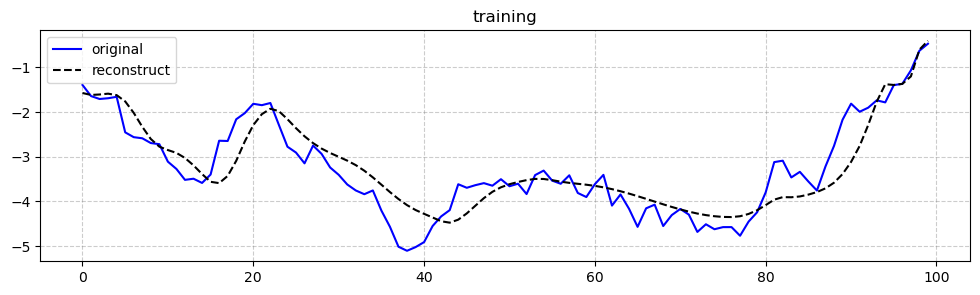

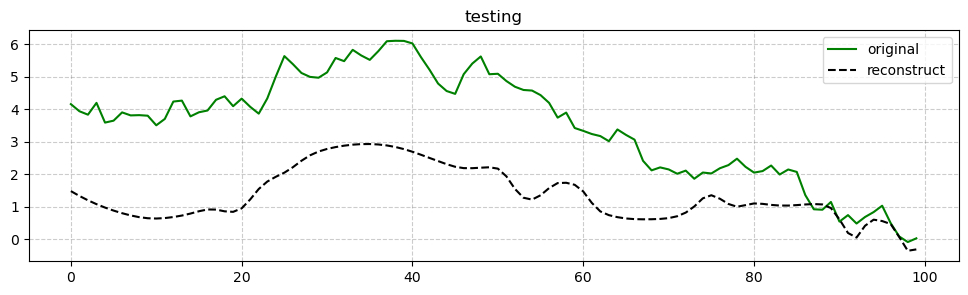

In [7]:
import torch.optim as optim
from torch.utils.data import DataLoader
tr_set = DataLoader(x, batch_size=128, shuffle=True, drop_last=True)
val_set = DataLoader(val_x, batch_size=128, shuffle=True, drop_last=True)
from IPython.display import clear_output
OPT = optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.L1Loss(reduction = 'mean')
tr_loss = list()
val_loss = list()
for epoch in range(1, 1000 + 1):
    model.train()
    tr_loss_val = 0
    for tr in tr_set:
        OPT.zero_grad()
        x_hat = model(x)
        loss = criterion(x_hat, x)
        tr_loss_val += float(loss)
        loss.backward()
        OPT.step()
    tr_loss += [float(tr_loss_val)]

    model.eval()
    val_loss_val = 0
    with torch.no_grad():
        for val in val_set:
            val_x_hat = model(x)
            loss = criterion(val_x_hat, x)
            val_loss_val += float(loss)
    val_loss += [float(val_loss_val)]
    
    if epoch%10 == 0:
        model.eval()
        with torch.no_grad():
            clear_output()
            plt.figure(figsize = (12, 3))
            plt.plot(x[0].detach().cpu(), color = "blue", label = "original")
            plt.plot(model(x)[0].detach().cpu(), color = "black", label = "reconstruct", linestyle = '--')
            plt.grid(linestyle = '--', color = 'gray', alpha = .4)
            plt.title("training")
            plt.legend()
            plt.show()
            model.eval()
            
            plt.figure(figsize = (12, 3))
            plt.plot(val_x[0].detach().cpu(), color = "green", label = "original")
            plt.plot(model(val_x)[0].detach().cpu(), color = "black", label = "reconstruct", linestyle = '--')
            plt.grid(linestyle = '--', color = 'gray', alpha = .4)
            plt.title("testing")
            plt.legend()
            plt.show()


# 訓練集

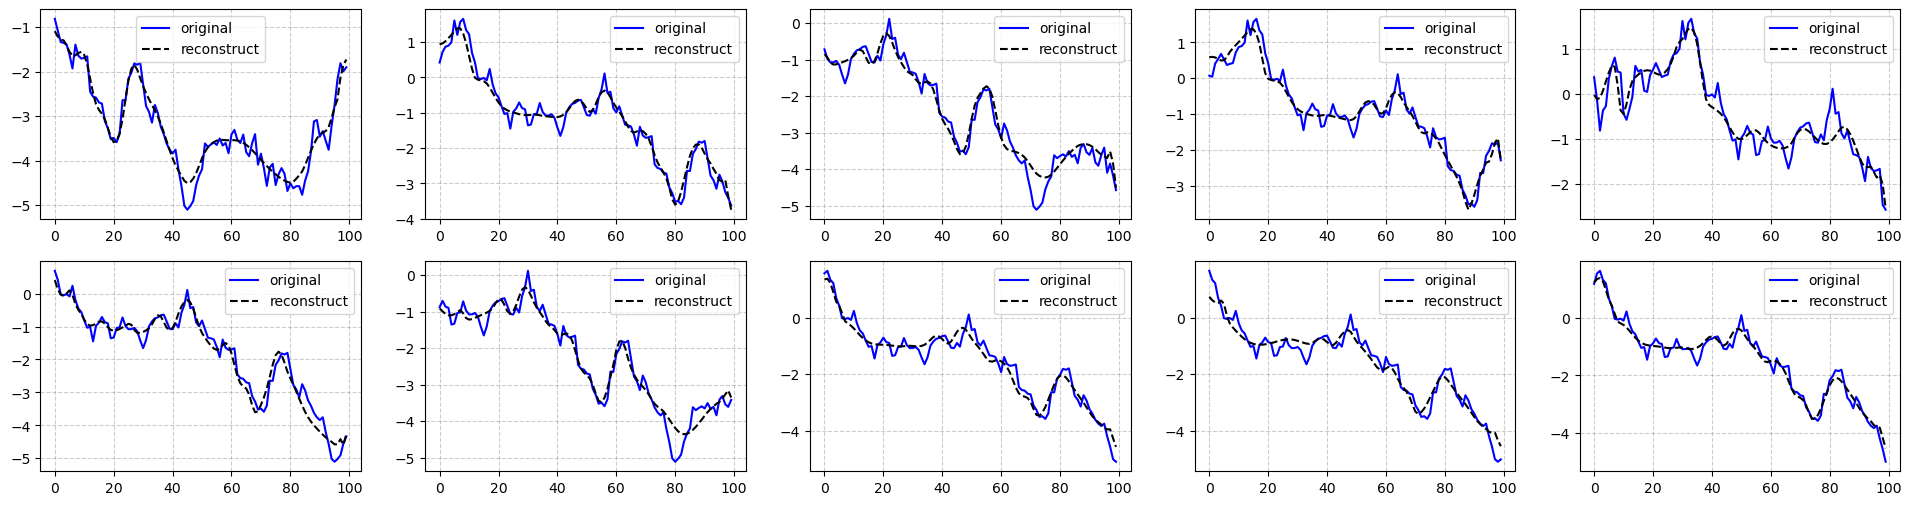

In [8]:
idxs = np.random.randint(0, 100, size = 10).tolist()
fig, axs = plt.subplots(2, 5, figsize = (24, 6))
for i, idx  in enumerate(idxs):
    axs[i//5][i%5].plot(x[idx].detach().cpu(), color = "blue", label = "original")
    axs[i//5][i%5].plot(x_hat[idx].detach().cpu(), color = "black", label = "reconstruct", linestyle = '--')
    axs[i//5][i%5].grid(linestyle = '--', color = 'gray', alpha = .4)
    axs[i//5][i%5].legend()
fig.show()

# 測試集

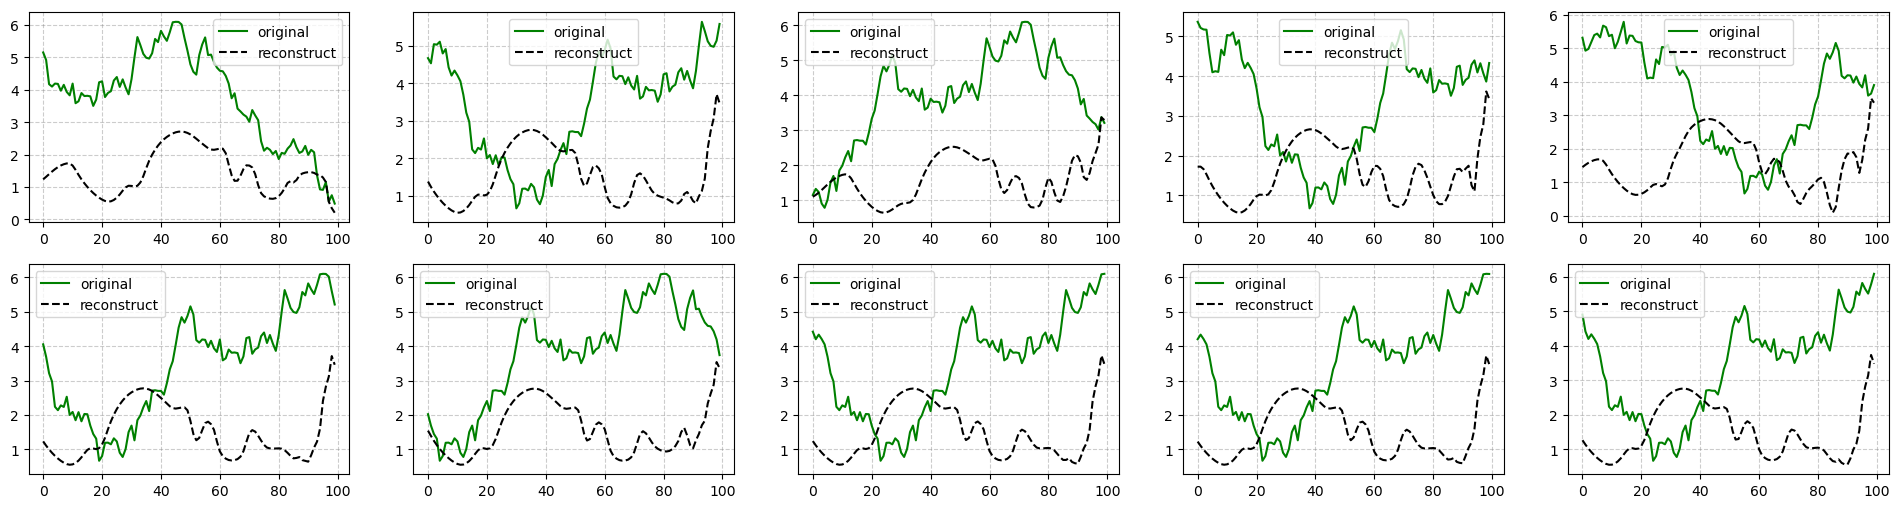

In [10]:
idx = np.random.randint(0, 100, size = 10).tolist()
val_x_hat = model(val_x)
fig, axs = plt.subplots(2, 5, figsize = (24, 6))
for i, idx  in enumerate(idxs):
    axs[i//5][i%5].plot(val_x[idx].detach().cpu(), color = "green", label = "original")
    axs[i//5][i%5].plot(val_x_hat[idx].detach().cpu(), color = "black", label = "reconstruct", linestyle = '--')
    axs[i//5][i%5].grid(linestyle = '--', color = 'gray', alpha = .4)
    axs[i//5][i%5].legend()
fig.show()

# Latent Space

In [12]:
from sklearn.manifold import TSNE
dots = model.encoder(x)[0].squeeze()
dots = torch.cat([dots, model.encoder(val_x)[0].squeeze()])

In [13]:
tsne = TSNE(n_components=2)
dots_tsne = tsne.fit_transform(dots.detach().cpu())

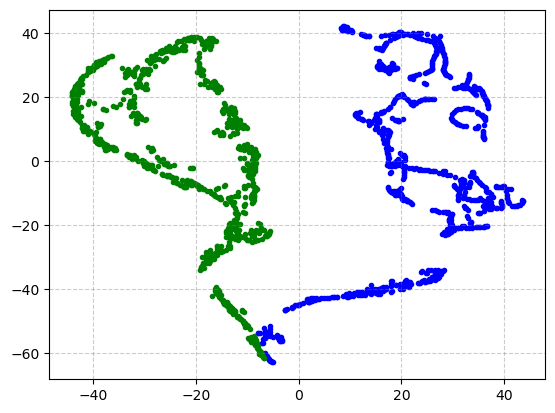

In [14]:
plt.scatter(dots_tsne[:x.shape[0], 0], dots_tsne[:x.shape[0], 1], color = "blue", marker = ".")
plt.scatter(dots_tsne[x.shape[0]:, 0], dots_tsne[x.shape[0]:, 1], color = "green", marker = ".")
plt.grid(linestyle = "--", color = 'gray', alpha = .4)
plt.show()